<a href="https://colab.research.google.com/github/Kaguya2906/Anomaly_Detection_Weekly_Project/blob/main/09.%20OverSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## What is imbalanced data?

The definition of imbalanced data is straightforward. A dataset is imbalanced if at least one of the classes constitutes only a very small minority. Imbalanced data prevail in banking, insurance, engineering, and many other fields. It is common in fraud detection that the imbalance is on the order of 100 to 1.

## What are the remedies?
Broadly speaking there are three major approaches to handling imbalanced data: data sampling, algorithm modifications, and cost-sensitive learning. In 08 and 09, we'll include the use of the sampling methods(OverSampling, UnderSampling)

# Libraries, Dataset

In [ ]:
#pip install h2o

In [ ]:
import pandas as pd
from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN)

In [ ]:
df = pd.read_csv("MortgageDefault_Cleaned.csv")

# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['loan_default'])
y = df['loan_default']

# Splitting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# ROC_AUC Func

In [ ]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual['loan_default'],y_pred['p1'])
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual['loan_default'],y_pred['p1'])

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual['loan_default'],y_pred['p1'])
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

# Using oversampling techniques

Oversampling increases the weight of the minority class by replicating the minority class examples. Although it does not increase information, it raises the over-fitting issue, which causes the model to be too specific. It may well be the case that the accuracy for the training set is high, yet the performance for new datasets is worse.

# (A)RandomOverSampler
A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to the loss of information. But if the examples of the majority class are near to others, this method might yield good results.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = RandomOverSampler(sampling_strategy=0.8)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 52 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_hp7ixq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.153 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
RF_over = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_over.train(x = predictors,
              y = target,
              training_frame = train_hex)

drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1689965995585_41


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    500                500                         733290                 10           10           10            92            126           111.676

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.2236102705572512
RMSE: 0.4728744765339436
LogLoss: 0.6383103776391957
Mean Per-Class Error: 0.39270071737482964
AUC: 0.6902783671623809
AUCPR: 0.6261787210982439
Gini: 0.3805567343247618

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3639763690781488
       0     1      Error    Rate
-----  ----  -----  -------  -----------------
0      4853  9944   0.672    (9944.0/14797.0)
1      1342  10495  0.1134   (1342.0/11837.0)
Total  6195  20439  0.4237   (11286.0/26634.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363976     0.650328  283
max f2                       0.271909     0.803505  359
max f0point5                 0.468187     0.595271  178
max accuracy                 0.476015     0.642374  170
max precision                0.736519     1         0
max recall                   0.183659     1         395
max specificity              0.736519     1         0
max absolute_mcc             0.416347     0.272477  231
max min_per_class_accuracy   0.445415     0.632561  201
max mean_per_class_accuracy  0.436105     0.63556   210
max tns                      0.736519     14797     0
max fns                      0.736519     11831     0
max fps                      0.152342     14797     399
max tps                      0.183659     11837     395
max tnr                      0.736519     1         0
max fnr                      0.736519     0.999493  0
max fpr                      0.152342     1         399
max tpr                      0.183659     1         395

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 44.43 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100248                   0.675386           1.86241   1.86241            0.827715         0.694114  0.827715                    0.694114            0.0186703       0.0186703                  86.2412   86.2412            0.0155615
2        0.020012                    0.652115           1.77637   1.81947            0.789474         0.662858  0.80863                     0.678515            0.017741        0.0364113                  77.6366   81.947             0.029518
3        0.0299992                   0.637721           1.63256   1.75725            0.725564         0.644289  0.780976                    0.66712             0.0163048       0.0527161                  63.2565   75.7246            0.0408893
4        0.040024                    0.626496           1.66859   1.73504            0.741573         0.631939  0.771107                    0.658308            0.0167272       0.0694433                  66.8586   73.5039            0.0529534
5        0.0500113                   0.618141           1.70024   1.72809            0.755639         0.622478  0.768018                   

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


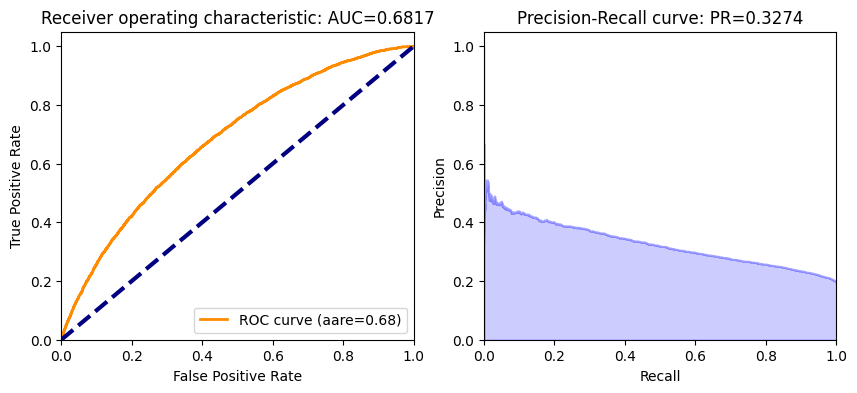

In [ ]:
ROC_AUC(RF_over,test_hex,'loan_default')

# (B)Synthetic Minority Oversampling Technique (SMOTE)

To avoid the over-fitting problem, Chawla et al. (2002) propose the Synthetic Minority Over-sampling Technique (SMOTE). This method is considered a state-of-art technique and works well in various applications. This method generates synthetic data based on the feature space similarities between existing minority instances. To create a synthetic instance, it finds the K-nearest neighbors of each minority instance, randomly selects one of them and then calculates linear interpolations to produce a new minority instance in the neighborhood.

In [ ]:
from imblearn.over_sampling import SMOTE
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = SMOTE(sampling_strategy=0.8)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,18 mins 17 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_hp7ixq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.015 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
RF_over = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_over.train(x = predictors,
              y = target,
              training_frame = train_hex)

drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1689965995585_759


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    500                500                         1.45528e+06            10           10           10            170           274           226.834

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.13389208033357083
RMSE: 0.3659126676320059
LogLoss: 0.4338399251787892
Mean Per-Class Error: 0.16819527090802872
AUC: 0.8972602375114949
AUCPR: 0.9099883844742768
Gini: 0.7945204750229897

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668890139211679
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      40216  3026   0.07     (3026.0/43242.0)
1      9216   25377  0.2664   (9216.0/34593.0)
Total  49432  28403  0.1573   (12242.0/77835.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466889     0.80567   198
max f2                       0.277774     0.8328    301
max f0point5                 0.55671      0.885519  159
max accuracy                 0.497794     0.845147  184
max precision                0.987131     1         0
max recall                   0.0580628    1         399
max specificity              0.987131     1         0
max absolute_mcc             0.515615     0.698864  176
max min_per_class_accuracy   0.389366     0.812216  239
max mean_per_class_accuracy  0.476831     0.832562  193
max tns                      0.987131     43242     0
max fns                      0.987131     34579     0
max fps                      0.0580628    43242     399
max tps                      0.0580628    34593     399
max tnr                      0.987131     1         0
max fnr                      0.987131     0.999595  0
max fpr                      0.0580628    1         399
max tpr                      0.0580628    1         399

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 44.44 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100084                   0.950261           2.25002   2.25002            1                0.963598  1                           0.963598            0.022519        0.022519                   125.002   125.002            0.022519
2        0.0200039                   0.933191           2.25002   2.25002            1                0.94144   1                           0.952526            0.0224901       0.0450091                  125.002   125.002            0.0450091
3        0.0300122                   0.917751           2.25002   2.25002            1                0.925211  1                           0.943417            0.022519        0.0675281                  125.002   125.002            0.0675281
4        0.0400077                   0.90275            2.25002   2.25002            1                0.910559  1                           0.935208            0.0224901       0.0900182                  125.002   125.002            0.0900182
5        0.0500032                   0.890933           2.25002   2.25002            1                0.896853  1                   

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


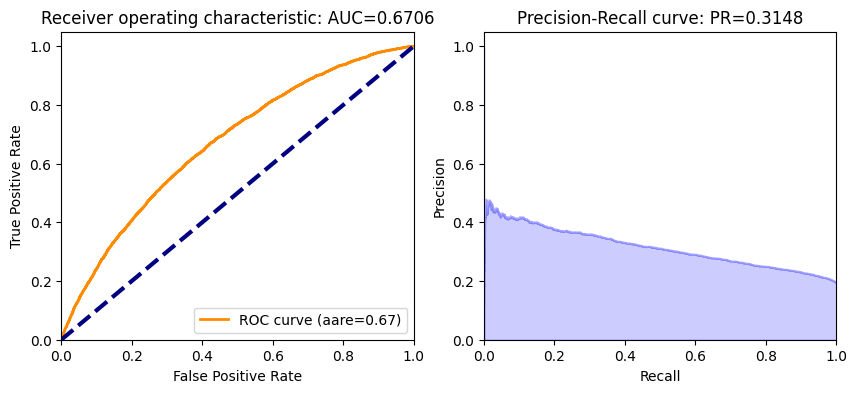

In [ ]:
ROC_AUC(RF_over,test_hex,'loan_default')

# (C)ADASYN

ADASYN generates samples of the minority class according to their density distributions. More synthetic data is generated for minority class samples that are harder to learn, compared to those minority samples that are easier to learn. It calculates the K-nearest neighbors of each minority instance, then gets the class ratio of the minority and majority instances to generate new samples. Repeating this process adaptively shifts the decision boundary to focus on those samples that are difficult to learn.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,55 mins 59 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_hp7ixq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.846 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


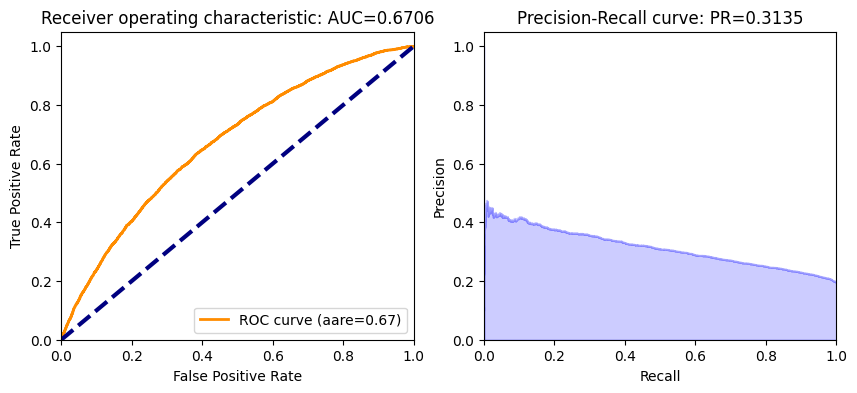

In [ ]:
from imblearn.over_sampling import ADASYN
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = ADASYN(sampling_strategy=0.8)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

RF_over = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_over.train(x = predictors,
              y = target,
              training_frame = train_hex)

ROC_AUC(RF_over,test_hex,'loan_default')